# Plotting auxiliary spectra

We will download some noise-monitoring data from LIGO and play it as a sound.

(The following two cells of code are preliminaries which you can skip.)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns

from gwpy.detector import ChannelList, Channel
from gwpy.timeseries import TimeSeries
from gwpy.time import tconvert

from gwosc.datasets import event_gps
import os

from scipy.io.wavfile import write as write_wav

from tqdm.notebook import tqdm

## Available channels

Let's retrieve a list of all available channels from GWOSC, and see how they are distributed in terms of sampling rate and detector.

In [3]:
channel_list = ChannelList.query_nds2('*', host='losc-nds.ligo.org' )

print("Found {0} channels\n".format(len(channel_list)))
print("Printing first 10 channels ...")
for chan in channel_list[0:10]:
    print(chan.name, chan.sample_rate)

Found 1263 channels

Printing first 10 channels ...
H1:ASC-AS_A_DC_NSUM_OUT_DQ 2048.0 Hz
H1:ASC-CHARD_P_IN1_DQ 256.0 Hz
H1:ASC-CHARD_P_INMON 16.0 Hz
H1:ASC-CHARD_P_OUT_DQ 512.0 Hz
H1:ASC-CHARD_Y_IN1_DQ 256.0 Hz
H1:ASC-CHARD_Y_INMON 16.0 Hz
H1:ASC-CHARD_Y_OUT_DQ 512.0 Hz
H1:ASC-CSOFT_P_IN1_DQ 256.0 Hz
H1:ASC-CSOFT_P_INMON 16.0 Hz
H1:ASC-CSOFT_P_OUT_DQ 512.0 Hz


There are 1263 channels in total.


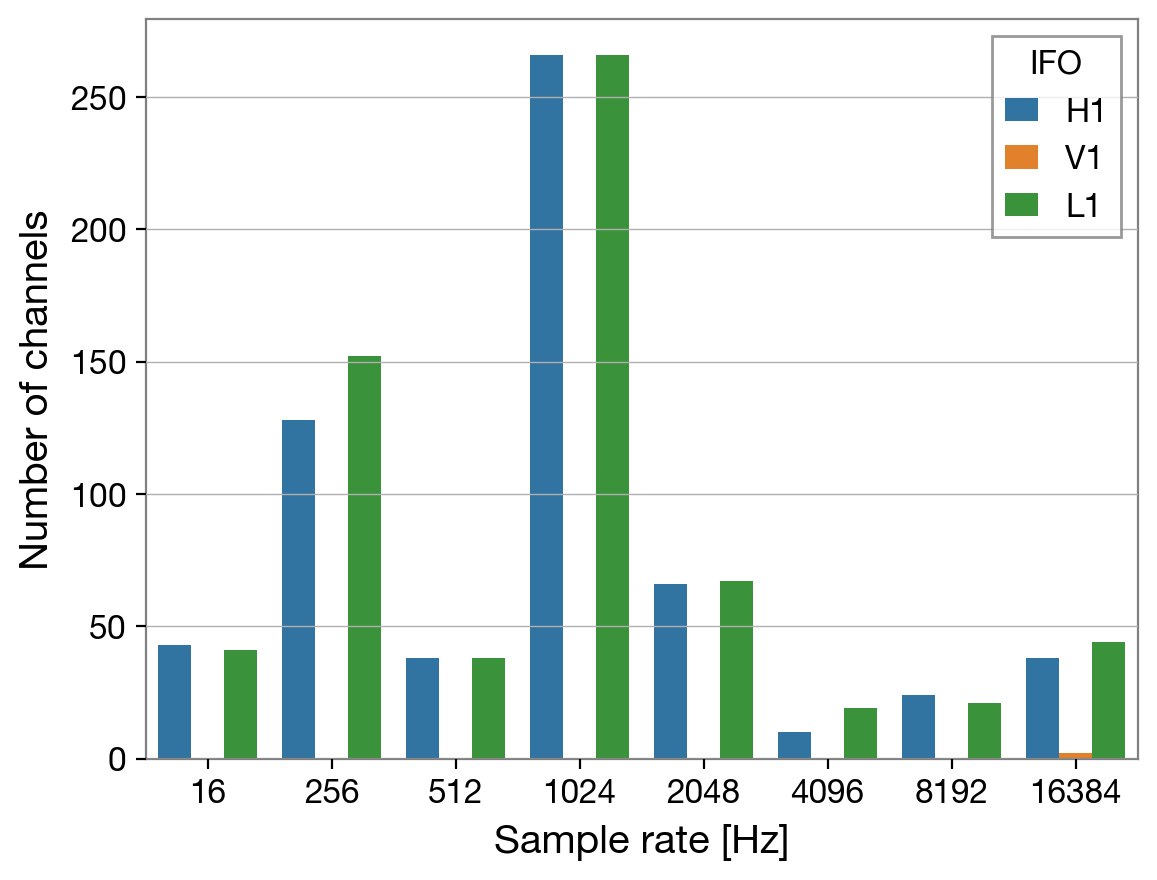

In [4]:
sample_rates = sorted(list(set([int(chan.sample_rate.value) for chan in channel_list])))
detectors = list(set([chan.ifo for chan in channel_list]))

rows = []
for sr in sample_rates:
    channels = [c for c in channel_list if c.sample_rate.value == sr]
    for ifo in detectors:
        channels_ifo = [c for c in channels if c.ifo == ifo]
        rows.append(dict(IFO=ifo, sample_rate=sr, n_channels=len(channels_ifo)))
        # print(f"There are {len(channels_ifo)} {ifo} channels sampled at {sr} Hz")
df = pd.DataFrame(rows)

ax = sns.barplot(df, x='sample_rate', y='n_channels', hue='IFO')
ax.set_ylabel('Number of channels')
ax.set_xlabel('Sample rate [Hz]');

print("There are {0} channels in total.".format(len(channel_list)))

## Channel properties

In [5]:
bad_times_dict = {
    'H1': [ (1239130112, 1239134208)],
    'L1': [(1247261568, 1247261824),
        (1266183936, 1266185600),
        (1267377472, 1267377600),
        (1267377664, 1267377728),
        (1267556672, 1267557056),
        (1267559296, 1267559424),
        (1267564160, 1267564480),
        (1268516633, 1268516672)]
}

In [8]:
t0 = event_gps("GW190521")

outdir_tmp = "data/{ifo}/{srate}/{channel}"

playback_rate = 16384
target_duration = 8
gain_factor = 1

# GWOSC NDS2 server name from which to download data
server = 'losc-nds.ligo.org'

FORCE = False

In [11]:
failed_channels = []
success_channels = []
plot_failed = []
for c in tqdm(channel_list):
    
    upsampling_factor = playback_rate / c.sample_rate.value
    duration = target_duration * upsampling_factor

    outdir = outdir_tmp.format(ifo=c.ifo, srate=int(c.sample_rate.value), channel=c.name)
    
    fname = f"out_{c.name.replace(':','-')}_rate-{playback_rate}_gain-{gain_factor}.wav"
    fpath = os.path.join(outdir, fname)

    if not os.path.exists(fpath) or FORCE:

        start_time = int(t0 - duration / 2)
        end_time = int(t0 + duration / 2)

        # check times
        for bad_start, bad_end in bad_times_dict[c.ifo]:
            if (bad_start <= start_time < bad_end) or (bad_start < end_time <= bad_end):
                print("Bad time for {0}: {1} - {2}".format(ifo, bad_start, bad_end))
                continue
        
        try:
            data = TimeSeries.fetch(c.name, start=start_time, end=end_time, host=server)
            success_channels.append(c.name)
        except ValueError:
            failed_channels.append(c.name)
            continue

        data.override_unit('')

        if not os.path.exists(outdir):
            os.makedirs(outdir)
    
        # record start and end time to file
        with open(os.path.join(outdir, "time.txt"), 'w') as f:
            f.write("{0} {1}".format(start_time, end_time))
            
        # plot data
        try:
            f = data.plot(ylabel="Data", title=c.name, epoch=start_time);
            f.savefig(os.path.join(outdir, "data_time.png"), bbox_inches='tight')
            f.close()

            data_asd = data.asd(4, 2)
            data_asd.override_unit('')
            f = data_asd.plot(xscale='log', yscale='log', ylabel="ASD", title=c.name);
            f.savefig(os.path.join(outdir, "data_asd.png"), bbox_inches='tight');
            f.close()

            specgram = data.spectrogram(4) ** (1/2.)
            f = specgram.imshow(norm='log');
            f.savefig(os.path.join(outdir, "data_spectrogram.png"), bbox_inches='tight');
            f.close()
        except ValueError:
            plot_failed.append(c.name)

        try:
            # Ensure the data is in int16 format for WAV. You might need to scale it appropriately.
            d = data.value
            scaled_data = np.int16(d/np.max(np.abs(d)) * 32767)
            
            write_wav(fpath, playback_rate, scaled_data*gain_factor)
        except:
            failed_channels.append(c.name)

print("Failed channels: {0}".format(failed_channels))
print("Success channels: {0}".format(success_channels)) 


  0%|          | 0/1263 [00:00<?, ?it/s]

/opt/miniconda3/envs/gwtunes/lib/python3.11/site-packages/gwpy/plot/axes.py:187: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  super().draw(*args, **kwargs)
/var/folders/w6/_4dty3r148b5hwmmgykz3_d00001sb/T/ipykernel_48354/2437958932.py:63: RuntimeWarning: invalid value encountered in divide
  scaled_data = np.int16(d/np.max(np.abs(d)) * 32767)
/var/folders/w6/_4dty3r148b5hwmmgykz3_d00001sb/T/ipykernel_48354/2437958932.py:63: RuntimeWarning: invalid value encountered in cast
  scaled_data = np.int16(d/np.max(np.abs(d)) * 32767)


KeyError: 'V1'

ValueError: vmin must be less or equal to vmax

<Plot size 1200x600 with 1 Axes>

ValueError: vmin must be less or equal to vmax

<Plot size 1200x600 with 1 Axes>

ValueError: vmin must be less or equal to vmax

<Plot size 1200x600 with 1 Axes>

ValueError: vmin must be less or equal to vmax

<Plot size 1200x600 with 1 Axes>

ValueError: vmin must be less or equal to vmax

<Plot size 1200x600 with 1 Axes>

ValueError: vmin must be less or equal to vmax

<Plot size 1200x600 with 1 Axes>

ValueError: vmin must be less or equal to vmax

<Plot size 1200x600 with 1 Axes>

ValueError: vmin must be less or equal to vmax

<Plot size 1200x600 with 1 Axes>

ValueError: vmin must be less or equal to vmax

<Plot size 1200x600 with 1 Axes>